In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms, models
import os

In [2]:
# Data Transformation and data augmentation

data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),    # Resize and crop the image to size 0f 224 
        transforms.RandomHorizontalFlip(),    # Horizontally flips image
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    
    'val' : transforms.Compose([
        transforms.Resize(256),        #  Resizes the image to size 0f 256
        transforms.CenterCrop(224),    #  Crops the image to retain only the central region, discarding the outer portions.
                                       #  The center crop size is specified as 224x224 pixels.
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
}

In [3]:
# Define data directory

data_dir = 'Dataset'

# Creating a data loader
img_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train','val']}

In [4]:
data_loaders = {x : torch.utils.data.DataLoader(img_datasets[x],batch_size=4,shuffle=True,num_workers=4) for x in ['train','val']}
dataset_size = {x : len(img_datasets[x]) for x in ['train','val']}
print(dataset_size)

class_name = img_datasets['train'].classes
print(class_name)

{'train': 557, 'val': 140}
['cats', 'dogs']


In [5]:
# Loading the pre trained ResNet50 model

model = models.resnet18(pretrained = True)

#freezing all layer except final classification layer
for name,param in model.named_parameters():
    if 'fc' in name:
        param.requires_grad = True
    else :
        param.requires_grad = False
        
#Loss function and optimizers
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)

# device agnostic code
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
model = model.to(device)

C:\Users\hp\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# Training of the model

num_epochs = 10
for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in data_loaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_size[phase]
        epoch_acc = running_corrects.double() / dataset_size[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")

train Loss: 1.1918 Acc: 0.6858
val Loss: 0.2859 Acc: 0.8786
train Loss: 0.5500 Acc: 0.8007
val Loss: 0.1640 Acc: 0.9357
train Loss: 0.6109 Acc: 0.7899
val Loss: 0.1806 Acc: 0.9000
train Loss: 0.5470 Acc: 0.8025
val Loss: 0.2602 Acc: 0.9000
train Loss: 0.4018 Acc: 0.8456
val Loss: 0.1231 Acc: 0.9429
train Loss: 0.4646 Acc: 0.7917
val Loss: 0.1654 Acc: 0.9429
train Loss: 0.4373 Acc: 0.8187
val Loss: 0.2617 Acc: 0.9143
train Loss: 0.3804 Acc: 0.8420
val Loss: 0.1516 Acc: 0.9286
train Loss: 0.4076 Acc: 0.8294
val Loss: 0.1224 Acc: 0.9429
train Loss: 0.4818 Acc: 0.8169
val Loss: 0.1514 Acc: 0.9357
Training complete!


In [7]:
# Save the model
torch.save(model.state_dict(), 'classification_model.pth')

In [10]:
# Classification on the unseen images

import torch
from torchvision import models, transforms
from PIL import Image

#Loading the saved model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)
model.load_state_dict(torch.load('classification_model.pth'))
model.eval()

#create new model with updated final layer
new_model = models.resnet18(pretrained = True)
new_model.fc = nn.Linear(new_model.fc.in_features,2)

#Copytin the weight and biases from loaded model to new model
new_model.fc.weight.data = model.fc.weight.data[0:2]
new_model.fc.bias.data = model.fc.bias.data[0:2]

C:\Users\hp\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
# Loading and preprocessing the unseen data

image_path = 'dig_t2.jpeg'
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)

In [27]:
 # Inference Performing 
with torch.no_grad():
    output = model(input_batch)
    
# predicted class name
_,predicted_class = output.max(1)

#Mapping predicted class name to the class name
class_names = ['cats','dogs']
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is:{predicted_class_name}')

The predicted class is:dogs


<function matplotlib.pyplot.show(close=None, block=None)>

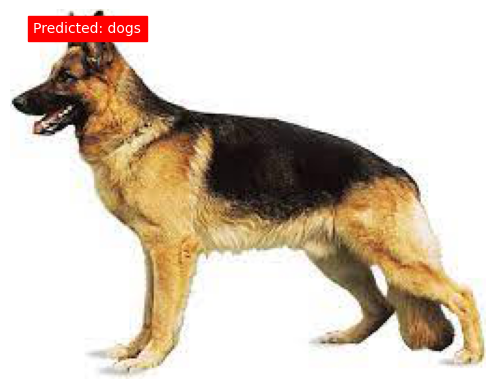

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

#Displaying image with predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(12,12, f'Predicted: {predicted_class_name}',fontsize = 10, color = 'white', backgroundcolor = 'red')
plt.show